**Imports**

In [1]:
# Imports und Funktions-Imports
# Standard- und externe Bibliotheken
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

# Eigene Funktions-Module für Daten, Berechnung und Steuerung
from functions.retro_data.weather_data import get_weather
from functions.retro_data.spotprice_data import get_spotprice
from functions.retro_data.consumption_data import get_demand
from functions.calculations.calculations import calculate_energy
from functions.calculations.kpis import calculate_kpis
from functions.deciding_functions.optimized import optimize_energy_flow
from functions.deciding_functions.reinforcementlearning.drqn_ems import EMSenv, reinforcement_learning_train, reinforcement_learning_test
from functions.deciding_functions.rulebased import rule_based_energy_flow
from functions.results.results import get_results

**Definition des Green Energy Ecosystems**

In [2]:
# Systemparameter und Annahmen
# Hier werden alle relevanten Systemparameter für PV, Wind, Batterie, Verbraucher etc. gesetzt.
# Werte können für Szenarien einfach angepasst werden.

# Photovoltaik
solar_peak_power = 38  # Spitzenleistung Gesamtsystem PV [MW]
num_modules = 114980 #Anzahl Solarmodule
area_per_module = 1.57458  # Fläche pro Modul [m²] (Annahme Heckert Solar NeMo® 2.0 330 Wp)
module_efficiency = 0.196  # Wirkungsgrad der Solarmodule (Annahme Heckert Solar NeMo® 2.0 330 Wp)
tilt_angle = 45  # Neigungswinkel der Solarpanels [°] (Annahme)
latitude=51.751111 # Breitengrad
longitude=4.208611 # Längengrad
azimuth=180 # Azimut [°]
albedo=0.2 # Albedo

# Windkraft 
wind_peak_power = 22   # Spitzenleistung Gesamtsystem Windkraft [MW]
r = 60 # Rotor Radius [m]
h = 90 # Höhe Windrad [m]
turbine_efficiency = 0.5  # Wirkungsgrad der Windkraftanlagen (Annahme)
cut_in = 2.5  # Einschaltgeschwindigkeit [m/s]
cut_out = 28  # Abschaltgeschwindigkeit [m/s]
num_turbines = 6 # Anzahl Windkraftanlagen

# Batteriespeicher
battery_capacity = 12  # [MWh]
soc = 0.5  # State of Charge (SOC) initial [0-1]
initial_battery = soc * battery_capacity  # [MWh]
charging_rate = 10  # Lade-/Entladerate [MW]
discharging_rate = 10

# Verbraucher
yearly_demand = 2.7  #  Verbrauch eines Haushalts/Jahr [MWh] (Annahme)
num_houses = 39000  # Anzahl Haushalte

# Strompreis
export_factor = 0.25   # Anteil vom Spotpreis für Einspeisung
price_low_quant  = 0.30   # Regelbasiert: Niedrigpreis-Schwelle

# Trainingsparameter
train_month = 4 # Startmonat für das Training (1 bis 12)
train_timeframe = 0  # Datensatz kürzen [Tage]
total_timesteps = 10_000  # Anzahl der Schritte für das Training des RL-Agenten

# Parameter für Sliding Window
test_month = 5  # Startmonat für das Sliding Window (1 bis 5)
test_timeframe = 7  # Datensatz kürzen [Tage]
forecast_horizon = 48  # Länge des Fensters [Tagen]
stepsize = 1    # Schrittweite [Stunden]

**Vorbereiten der Datensätze**

In [3]:
# Daten laden und vorbereiten
# Wetter-, Preis- und Verbrauchsdaten werden geladen und zu einem DataFrame zusammengeführt.

# Daten laden
# (liefert DataFrames mit Zeitstempel)
df_weather = get_weather()
df_spot = get_spotprice()
df_demand = get_demand(num_houses, yearly_demand)

# Datensätze mergen (alle Zeitreihen auf gemeinsamen Zeitstempel bringen)
df_merged = df_weather.merge(
    df_spot[['datetime', 'spotprice']],
    on='datetime', how='left'
).merge(
    df_demand[['datetime', 'energy_demand']],
    on='datetime', how='left'
)

# Split: Erstes Jahr = Training, Rest = Test
df_merged["datetime"] = pd.to_datetime(df_merged["datetime"])
train_end = df_merged["datetime"].min() + pd.DateOffset(years=1)
df_train = df_merged[df_merged["datetime"] < train_end].reset_index(drop=True)
df_test = df_merged[df_merged["datetime"] >= train_end].reset_index(drop=True)

# Optional: Daten anzeigen
# display(df_weather.head(5)), display(df_spot.head(5)), display(df_demand.head(5))
# display(df_train.head(5)), display(df_test.head(5))
# display(df_merged.head(5))

In [4]:
# Datensätze zuschneiden (Sliding Window)
# Trainings- und Testdaten werden auf die gewünschten Zeiträume gekürzt.

# Testdatensatz: Startet im gewünschten Monat, Länge = test_timeframe Tage
test_month = df_test[
    (df_test["datetime"].dt.month == test_month)
]["datetime"].min()

start = test_month
end = start + pd.Timedelta(days=test_timeframe)

df_test = df_test[(df_test["datetime"] >= start) & (df_test["datetime"] < end)].reset_index(drop=True)

# Trainingsdatensatz: Startet im gleichen Monat, Länge = train_timeframe Tage
train_month = df_train[
    (df_train["datetime"].dt.month == train_month)
]["datetime"].min()

start = train_month
end = start + pd.Timedelta(days=train_timeframe)

df_train = df_train[(df_train["datetime"] >= start) & (df_train["datetime"] < end)].reset_index(drop=True)

# Optional: Daten anzeigen
# display(df_train.head()), display(df_test.head())
# print(len(df_train), len(df_test))

**Ausführen der Berechnungsfunktion**

In [5]:
# Energie- und Bedarfsberechnung für Trainings- und Testdaten
# Berechnet PV-/Wind-Ertrag und merged alle relevanten Spalten.

df_energy_test = calculate_energy(
    df_test, 
    solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
    wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines
)
df_test = df_energy_test.merge(
    df_spot[['datetime', 'spotprice']],
    on='datetime', how='left'
 ).merge(
    df_demand[['datetime', 'energy_demand']],
    on='datetime', how='left'
 ).reset_index(drop=True)

df_energy_train = calculate_energy(
    df_train, 
    solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
    wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines
)
df_train = df_energy_train.merge(
    df_spot[['datetime', 'spotprice']],
    on='datetime', how='left'
 ).merge(
    df_demand[['datetime', 'energy_demand']],
    on='datetime', how='left'
 ).reset_index(drop=True)

# Optional: Daten anzeigen
# display(df_train.head()), display(df_test.head())

**Plot der Energiedaten und relevanten Wetterdaten**

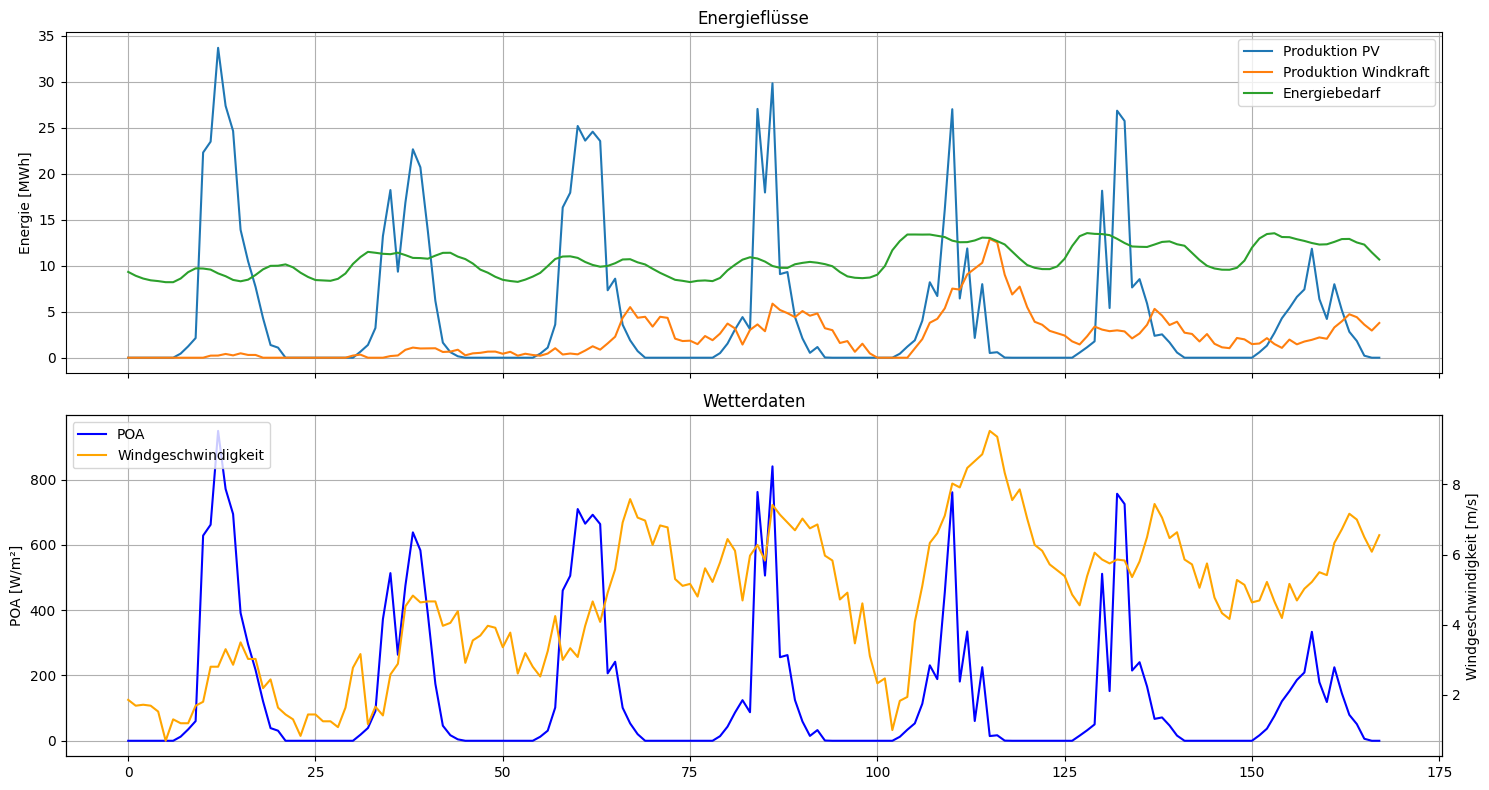

In [6]:
# Plot: Energie- und Wetterdaten (Testdaten)
# Visualisiert PV-/Wind-Erzeugung, Bedarf und Wetterdaten für den Testzeitraum.

df_plot = df_test.copy()

# Figure mit zwei Subplots (Energieflüsse und Wetter)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Energieflüsse
ax1.plot(df_plot.index, df_plot["solar_energy_production"], label="Produktion PV")
ax1.plot(df_plot.index, df_plot["wind_energy_production"], label="Produktion Windkraft")
ax1.plot(df_plot.index, df_plot["energy_demand"], label="Energiebedarf")
ax1.set_ylabel("Energie [MWh]")
ax1.set_title("Energieflüsse")
ax1.legend()
ax1.grid(True)

# Wetterdaten (POA und Windgeschwindigkeit)
ax2a = ax2  # linke Achse
ax2b = ax2a.twinx()  # rechte Achse

line1, = ax2a.plot(df_plot.index, df_plot["poa_irradiance"], color="blue", label="POA")
line2, = ax2b.plot(df_plot.index, df_plot["windspeed"] / 3.6, color="orange", label="Windgeschwindigkeit")

ax2a.set_ylabel("POA [W/m²]")
ax2a.tick_params(axis='y')
ax2b.set_ylabel("Windgeschwindigkeit [m/s]")
ax2b.tick_params(axis='y')
ax2a.set_title("Wetterdaten")

# Gemeinsame Legende unten
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax2.grid(True)
ax2a.legend(lines, labels, loc="upper left")

plt.xlabel("Zeit")
plt.tight_layout()
plt.show()

**Ausführen der Entscheidungs-Funktionen**

In [7]:
# Regelbasierte Steuerung (Testdaten)
# Einfache Heuristik für Batterie- und Netzmanagement.

result_df_rule = rule_based_energy_flow(
    df_test, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, price_low_quant
    )

result_kpis_rule = calculate_kpis(result_df_rule, export_factor)

In [8]:
forecast_horizon_short = 1  # Länge des Fensters [Tagen]
result_df_opt = optimize_energy_flow(
    df_test, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, 
    forecast_horizon_short, stepsize
    )

result_kpis_opt = calculate_kpis(result_df_opt, export_factor)

In [9]:
result_df_opt_fore = optimize_energy_flow(
    df_test, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, 
    forecast_horizon, stepsize
    )

result_kpis_opt_fore = calculate_kpis(result_df_opt_fore, export_factor)

Regelbasiert:
Netto Stromkosten: 78392.85 €
Netzstromkosten: 77518.13 €
Einspeisevergütung: -874.72 €
Export-gewichteter Preis (rule): -10.17 €/MWh
Netzbezug: 898.71 MWh
Einspeisung: 343.89 MWh
Batterieladung: 106.05 MWh
Batterieentladung: 112.05 MWh
----------------------
Optimiert (ohne Prognose):
Netto Stromkosten: 78154.33 €
Netzstromkosten: 76656.88 €
Einspeisevergütung: -1497.46 €
Export-gewichteter Preis (opt):  -9.48 €/MWh
Netzbezug: 1180.01 MWh
Einspeisung: 632.08 MWh
Batterieladung: 48.00 MWh
Batterieentladung: 54.00 MWh
----------------------
Optimiert (mit Prognose):
Netto Stromkosten: 65381.96 €
Netzstromkosten: 63297.53 €
Einspeisevergütung: -2084.43 €
Export-gewichteter Preis (RL):  -14.78 €/MWh
Netzbezug: 1112.06 MWh
Einspeisung: 564.13 MWh
Batterieladung: 184.01 MWh
Batterieentladung: 190.01 MWh
----------------------


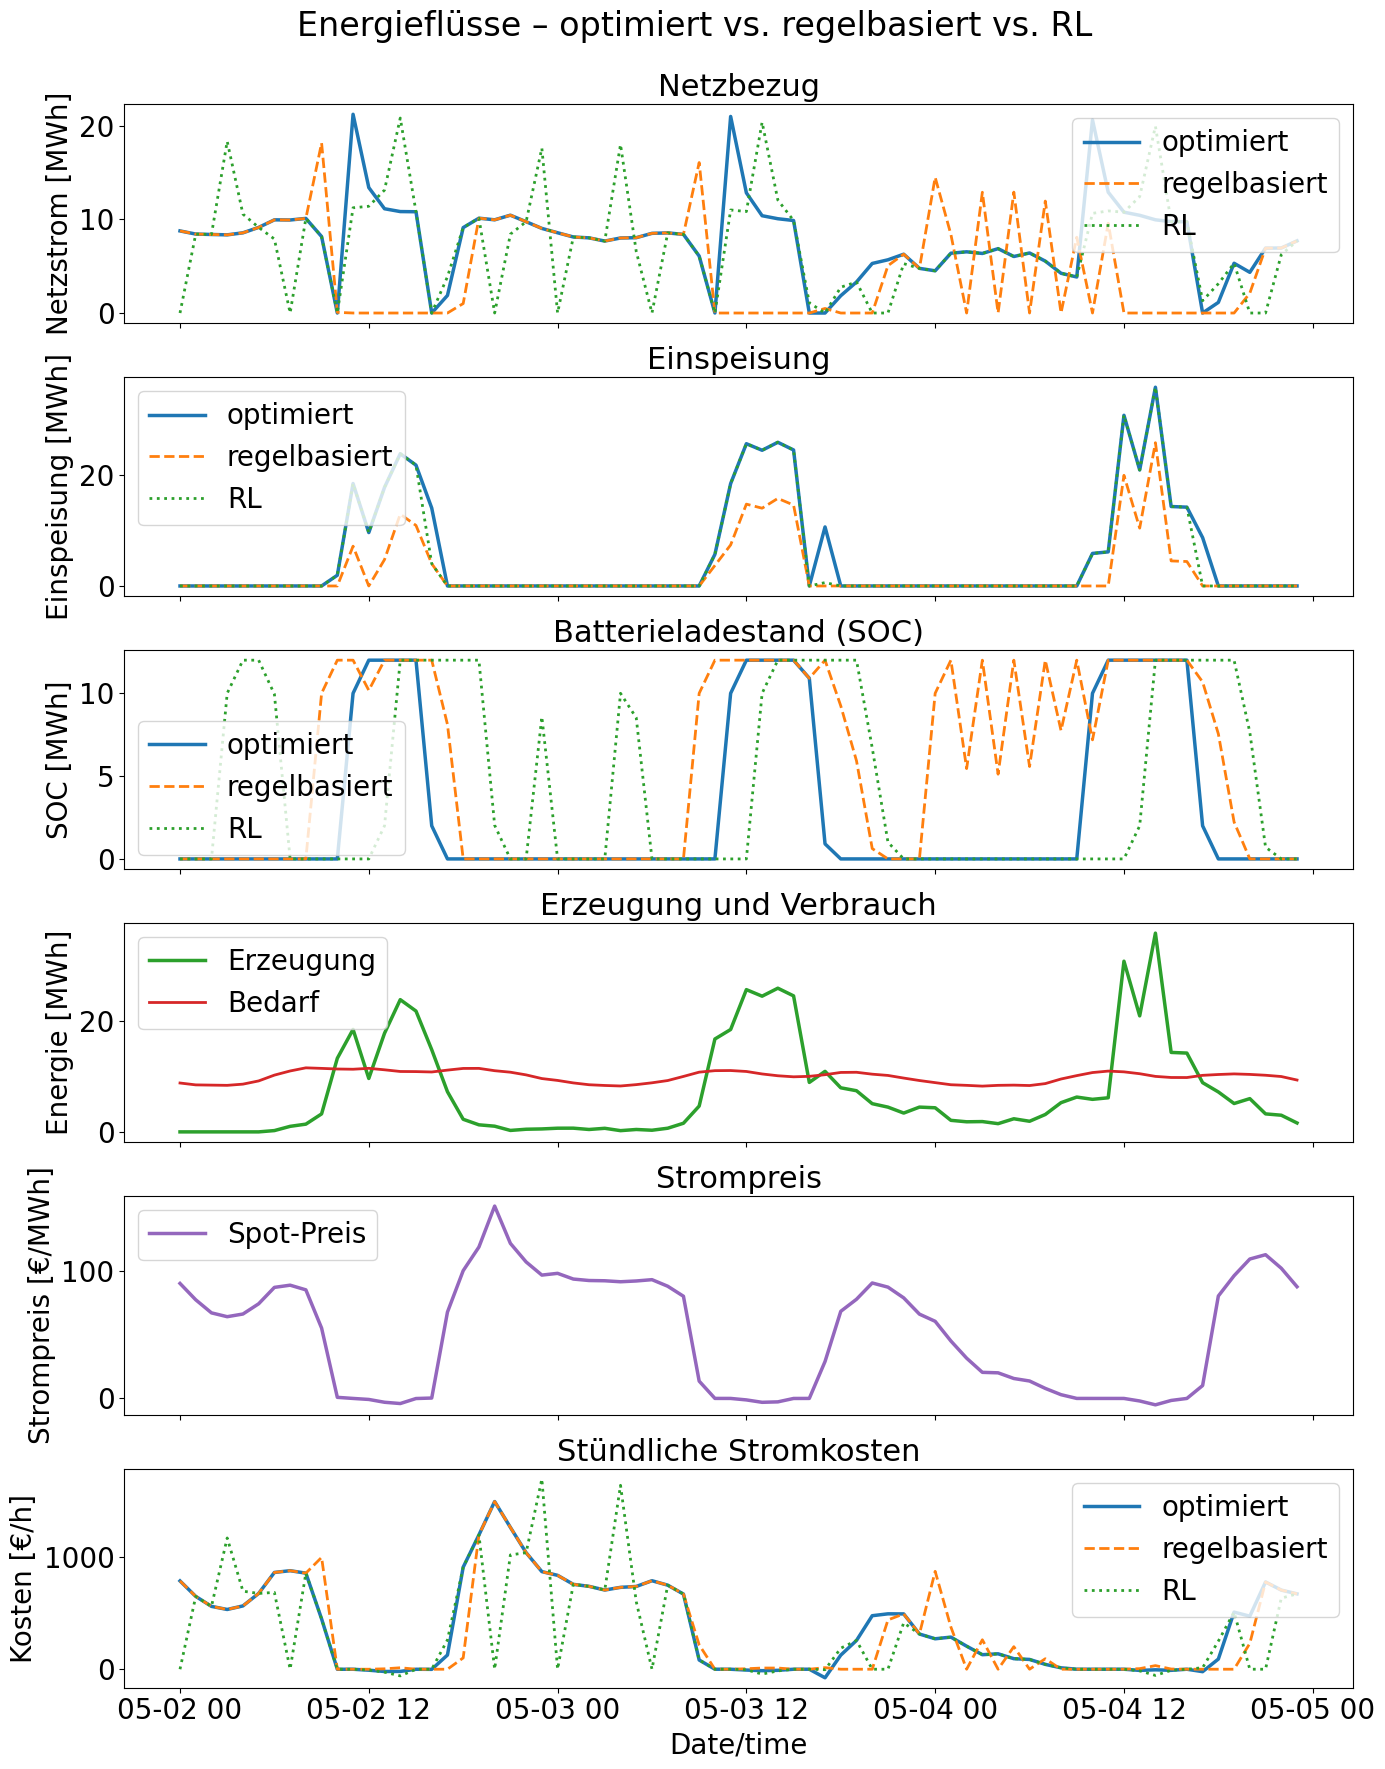

In [10]:
# Ergebnisfunktion: KPIs und Vergleich
# Gibt die wichtigsten Kennzahlen und Vergleiche für alle Ansätze aus.
get_results(result_df_rule, result_df_opt, result_df_opt_fore, result_kpis_rule, result_kpis_opt, result_kpis_opt_fore, export_factor)